<a href="https://colab.research.google.com/github/saliimranz/TalkFile/blob/main/TalkFile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.2/145.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.1/434.1 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 9.7 MB/s eta 0:00:00


In [3]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

··········


Gemni Free Api Setup

In [4]:
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

Enter your Google AI API key: ··········


In [5]:
!pip install -qU langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.4 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.17 which is incompatible.


In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-001",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

Hugging face for Embedding

In [7]:
pip install -qU langchain-huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.2 MB/s eta 0:00:00


In [8]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Chroma Setup

In [9]:
pip install -qU langchain-chroma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.0 MB/s eta 0:00:0

In [10]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

Load Documents

In [11]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43130


In [12]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


Splitting Documents

In [13]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


Storing Docs

In [14]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['61bf73f6-f7d7-47e9-bb0e-c381779b0abd', 'a9373619-274a-4ba2-8600-51a0065dd5b0', '89706ffe-e84c-4b8f-ac52-77f3e7db3c3d']


2. Retrival and Generation

In [15]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


State(Pydantic) and Control Flow

In [16]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict
from langgraph.graph import START, StateGraph
from typing import Literal
from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()



Visualize

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [18]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

ValueError: Expected where to be a dict, got <function retrieve.<locals>.<lambda> at 0x7c2812e1fe20> in query.

Stream Steps

In [19]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'beginning'}}}

----------------



ValueError: Expected where to be a dict, got <function retrieve.<locals>.<lambda> at 0x7c299df6f9c0> in query.

Custom Prompt

In [20]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

Query Analysis

In [21]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

In [22]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

In [23]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='899f2566-2f09-4a72-aa00-12327b249757', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 39220, 'section': 'end'}, page_content='Finite context length: The restricted context capacity limits the inclusion of historical information, detailed instructions, API call context, and responses. The design of the system has to work with this limited communication bandwidth, while mechanisms like self-reflection to learn from past mistakes would benefit a lot from long or infinite context windows. Although vector stores and retrieval can provide access to a larger knowledge pool, their representation power is not as powerful as full attention.\n\n\nChallenges in long-term planning and task decomposition: Planning over a lengthy history and effectively exploring the solution space remain challenging. LLMs struggle to adj

# Part 2

In [24]:
%%capture --no-stderr
%pip install --upgrade --quiet langgraph langchain-community beautifulsoup4

In [25]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [26]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

Tools

In [27]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

Flow now

In [28]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

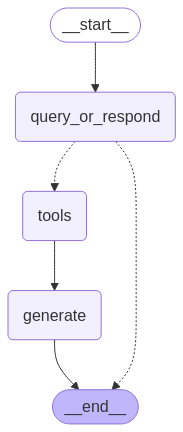

In [29]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I help you today?


In [31]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (8f652e82-18d6-4fcd-9f48-134d9dde6b04)
 Call ID: 8f652e82-18d6-4fcd-9f48-134d9dde6b04
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192, 'section': 'beginning'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM wi

In [32]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [33]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (573c134b-06e8-4402-ae22-1e00d4b81a86)
 Call ID: 573c134b-06e8-4402-ae22-1e00d4b81a86
  Args:
    query: Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192, 'section': 'beginning'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM wi

In [34]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (34802167-f987-4371-9857-a1035925725a)
 Call ID: 34802167-f987-4371-9857-a1035925725a
  Args:
    query: common methods task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192, 'section': 'beginning'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomp

Agents

In [35]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

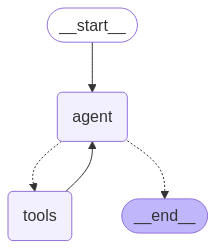

In [36]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [37]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (b2d81458-bccc-442f-b619-e55492d52871)
 Call ID: b2d81458-bccc-442f-b619-e55492d52871
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2192, 'section': 'beginning'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with ea